
# Introduction
Since news these days is published extremely fast, this leads to many news outlets not checking their sources before publishing, it is important to be able to quickly check the credibility of a news article. This project aims to do just that. It uses a dataset of fake news articles and a dataset of real news articles to train a model that can predict whether a news article is fake or real. The model is then used to predict the credibility of news articles.

<p align="center">
<img src="../image.jpg" width="1000" height="500">
</p>




# Pipeline Overview
This notebook starts by discussing the aim of the project and the data used. It then goes on to discuss the initial data analysis before the data cleaning and preprocessing steps taken.The following section discusses NLP and ways to vectorize text. The next section discusses the models used and the training and tuning process. The final section discusses the results of the model and the conclusions drawn from them.

# Data used and data preperation



The data used for this project is a combination of two datasets. The datasets used are from Kaggle and can be found here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [2]:
# Real and Fake news datasets from https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
f_df = pd.read_csv('../data/Fake.csv')
t_df = pd.read_csv('../data/True.csv')


### Data analysis and Merging datasets

##### Initial analysis of the datasets
We first want to understand the datasets and make use of usefull data within these datasets, thus we look at the columns and their types, the missingness of the data, the type of values in certain columns and the distribution of the data.

In [3]:
# Checking datasets have the same columns
print(f_df.columns)
print(t_df.columns)


Index(['title', 'text', 'subject', 'date'], dtype='object')
Index(['title', 'text', 'subject', 'date'], dtype='object')


In [4]:
# Checking for NaN values
print(f_df.isna().sum())
print()
print(t_df.isna().sum())


title      0
text       0
subject    0
date       0
dtype: int64

title      0
text       0
subject    0
date       0
dtype: int64


While both the real and fake datasets have no NaN values, this does not mean that the dataset is perfect.

We should be suspicious of any dataset (large or small) which appears perfect by David J. Hand

In [5]:
# checking types per column
f_df.dtypes


title      object
text       object
subject    object
date       object
dtype: object

In [6]:
# Checking subjects for real and fake news
print(f_df["subject"].unique())
print(t_df["subject"].unique())


['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politicsNews' 'worldnews']


Since the subjects of the fake and real datasets are different, we will not use these subjects because there is no interesection between the two datasets. We will also not use the date of the news report because it is not a good predictor of whether a news report is fake or real.

##### Adding a new column for each dataframe to identify if a news report is part of the real or fake dataset to prepare for concatenation
$fake = 0$

$real = 1$

In [7]:
f_df["type"] = 0
t_df["type"] = 1



Combining `text` and `title` columns into a single column `all_text` to prepare for concatenation and vectorization of the text

In [8]:
f_df["all_text"] = f_df["title"] + " " + f_df["text"]
t_df["all_text"] = t_df["title"] + " " + t_df["text"]

##### Concatenating the two datasets into a single dataframe

In [9]:
full_df = pd.concat([f_df[["all_text", "type"]],
                    t_df[["all_text", "type"]]], axis=0)
full_df.shape


(44898, 2)

In [10]:
full_df.head()


,all_text,type
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


### Data Analysis on the merged dataset

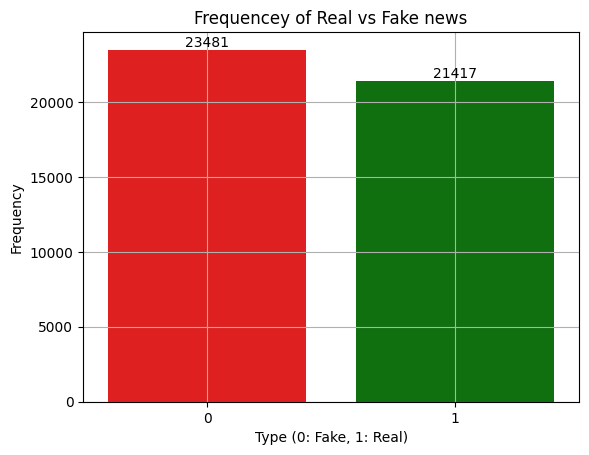

In [11]:
ax = sb.barplot(x=full_df.type.value_counts().index, y=full_df.type.value_counts(), palette=['red', 'green'])
ax.bar_label(ax.containers[0])
ax.set_ylabel("Frequency")
ax.set_xlabel("Type (0: Fake, 1: Real)")
ax.set_title("Frequencey of Real vs Fake news")
ax.grid()


From the above analysis, we can see that the dataset has similar amounts of real and fake news reports. This is a good sign as it means that the dataset is balanced and we can proceed with the analysis.

#### Natural Language Processing (NLP)
The next step to take is to convert the text of the news reports into a format that can be used by the machine learning model. This is done using NLP. The text is converted into a matrix of token counts. This matrix is then used to train the model.

##### Choosing how to vectorize the text

Options:
- TF-IDF
- Bert
- Word2Vec

##### TF-IDF
TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. It is calculated by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

##### Bert
Bert is a language model that uses a bidirectional encoder to learn the representation of words. It is a pre-trained model that can be used to convert text into a vector.

##### Word2Vec
Word2Vec is a model that learns the representation of words. It is a pre-trained model that can be used to convert text into a vector.



##### NLP data processing
I have chosen to explore Word2Vec. I chose Word2Vec over Bert because Bert is a large model and takes a long time to train. I chose Word2Vec over TF-IDF because TF-IDF is a statistical measure and does not learn the representation of words. Word2Vec is a model that learns the representation of words and is a better representation of the text.

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re
nltk.download('wordnet')
nltk.download('stopwords')
stopingwords = stopwords.words('english')
lemmentizer = WordNetLemmatizer()


def textCleaning(text):
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopingwords]
    text = [lemmentizer.lemmatize(word) for word in text]
    text = re.sub("[^a-zA-Z1-9]", " ", " ".join(text)).split()
    text = [word for word in text if len(word) > 1]
    text = re.sub(r'https?://\S+|www\.\S+', '', " ".join(text)).split()
    return text



[nltk_data] Downloading package wordnet to /home/matt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Preprocessing text
The text is preprocessed by converting the text to $lowercase$, removing $stopwords$, $lemmentizing$ the text, removing $urls$, and removing $punctuation$


In [13]:
cleaned_df = full_df.copy()
cleaned_df["cleaned_text"] = cleaned_df["all_text"].apply(textCleaning)


In [14]:
print(cleaned_df.iloc[100].cleaned_text)
print()
print(cleaned_df.iloc[100].all_text)

['watch', 'joe', 'biden', 'wrecked', 'trump', 'six', 'word', 'it', 'hilarious', 'former', 'vice', 'president', 'joe', 'biden', 'asked', 'monday', 'matt', 'lauer', 'nbc', 'today', 'name', 'something', 'specific', 'donald', 'trump', 'well', 'well', 'seems', 'like', 'trick', 'question', 'since', 'trump', 'passed', 'major', 'legislation', 'reach', 'across', 'aisle', 'take', 'shot', 'democrat', 'twitter', 'timeline', 'morning', 'rage', 'tweets', 'biden', 'struggled', 'find', 'something', 'anything', 'trump', 'done', 'well', 'since', 'taking', 'office', 'think', 'number', 'thing', 'well', 'even', 'thing', 'well', 'them', 'biden', 'said', 'tone', 'administration', 'bother', 'me', 'continued', 'due', 'respect', 'come', 'one', 'thing', 'think', 'well', 'lauer', 'said', 'well', 'think', 'married', 'well', 'biden', 'joked', 'although', 'biden', 'mention', 'trump', 'three', 'marriage', 'speaking', 'of', 'trump', 'first', 'marriage', 'ivana', 'ended', 'affair', 'marla', 'maples', 'trump', 'went', '

#### Analysing the frequency of words


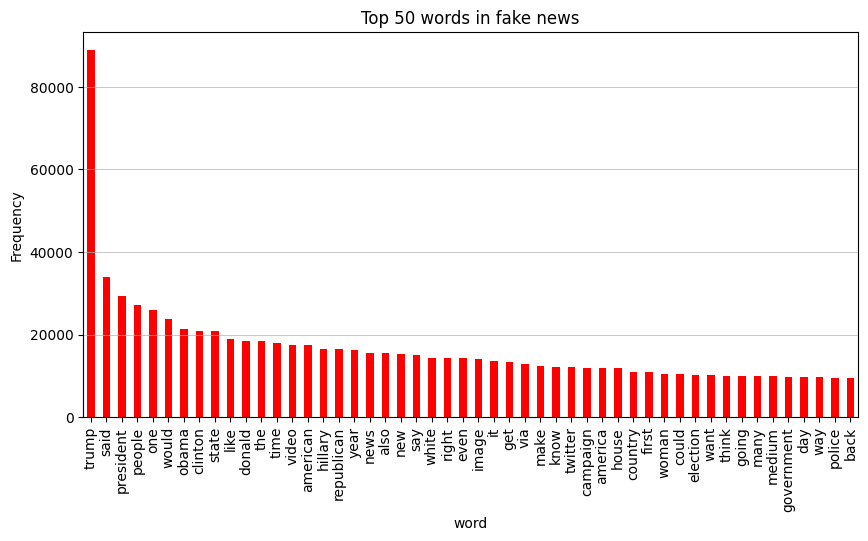

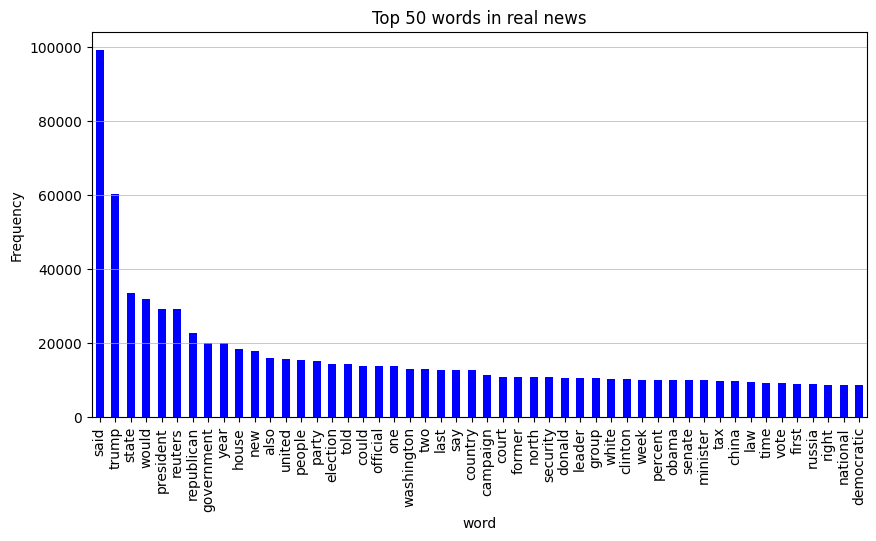

In [15]:
from matplotlib.pyplot import ticklabel_format, xticks
freq = cleaned_df[cleaned_df["type"] == 0]["cleaned_text"]
freqDict = {}
for i in freq:
    for j in i:
        if j in freqDict:
            freqDict[j] += 1
        else:
            freqDict[j] = 1
keys = list(freqDict.keys())
vals = list(freqDict.values())
freq_df = pd.DataFrame({"word": keys, "freq": vals})
freq_df.sort_values(by=["freq"], ascending=False, inplace=True)
freq_df.head(50).plot(kind="bar", x="word", y="freq", title="Top 50 words in fake news", color = "red", legend=False, figsize=(10, 5))
plt.grid(visible=True, axis="y", linestyle="-", linewidth=0.5)
plt.ylabel("Frequency")
plt.show()
freq = cleaned_df[cleaned_df["type"] == 1]["cleaned_text"]
freqDict = {}
for i in freq:
    for j in i:
        if j in freqDict:
            freqDict[j] += 1
        else:
            freqDict[j] = 1
keys = list(freqDict.keys())
vals = list(freqDict.values())
freq_df = pd.DataFrame({"word": keys, "freq": vals})
freq_df.sort_values(by=["freq"], ascending=False, inplace=True)
freq_df.head(50).plot(kind="bar", x="word", y="freq", title="Top 50 words in real news", color = "blue", legend=False, figsize=(10, 5))
plt.grid(visible=True, axis="y", linestyle="-", linewidth=0.5)
plt.ylabel("Frequency")
plt.show()

We can see that `said` and `trump` are the most frequent words in the dataset. We can also see that `trump` is the most frequent word in the fake news dataset and `said` is the most frequent word in the real news dataset. This is also not surprising as `trump` is a very controversial figure and `said` is a very common word in the English language.

#### Vectorizing text and splitting the dataset into training and testing sets

In [16]:
from sklearn.model_selection import train_test_split as tts

#### Word2Vec
Word2Vec is a model that learns the representation of words. It is a pre-trained model that can be used to convert text into a vector. Word2Vec was introduced by Tomas Mikolov et al. in 2013. It is a two-layer neural network that processes text. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. These vectors are used to represent words in the corpus. The vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

In [17]:
cleaned_df["cleaned_text"].head()

0    [donald, trump, sends, embarrassing, new, year...
1    [drunk, bragging, trump, staffer, started, rus...
2    [sheriff, david, clarke, becomes, internet, jo...
3    [trump, obsessed, even, obama, name, coded, we...
4    [pope, francis, called, donald, trump, christm...
Name: cleaned_text, dtype: object

In [18]:
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
emb = 100
word2vec = gensim.models.Word2Vec(sentences = cleaned_df["cleaned_text"], window = 50, min_count = 1)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_df["cleaned_text"])


2022-11-24 20:44:18.468244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 20:44:18.584652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 20:44:18.584675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-24 20:44:18.608795: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-24 20:44:19.405878: W tensorflow/stream_executor/platform/de

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
max = 100
tokenset = tokenizer.texts_to_sequences(cleaned_df["cleaned_text"])
paddedset = pad_sequences(tokenset, maxlen=max)
x_train, x_test, y_train, y_test = tts(paddedset, cleaned_df['type'], random_state=42, shuffle = True, test_size=0.2)
wordIndexLength = len(tokenizer.word_index) + 1

embedded_matrix = np.zeros((wordIndexLength, emb))
for i, j in tokenizer.word_index.items():
    embedded_matrix[j] = word2vec.wv[i]



### Neural Network Model

In this section, we will be using a neural network model to predict whether a news report is fake or real. The model is a sequential model with 3 layers. The first layer is an embedding layer which converts the text into a vector. The second layer is a LSTM layer which is a type of recurrent neural network. The third layer is a dense layer which is a fully connected layer. The model is compiled using the Adam optimizer and the binary crossentropy loss function. The model is trained for 10 epochs.

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.metrics import classification_report, accuracy_score

model = Sequential()
model.add(Embedding(wordIndexLength, output_dim=emb, weights=[embedded_matrix], input_length=emb, trainable=False))
model.add(LSTM(units=64))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


2022-11-24 20:46:12.085844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-24 20:46:12.085863: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 20:46:12.085882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matt-Latitude-7480): /proc/driver/nvidia/version does not exist
2022-11-24 20:46:12.086044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.fit(x_train, y_train, validation_split=0.3, epochs=10, batch_size=64, verbose=1)
model.save("model.h5")

Epoch 1/10


/home/matt/Desktop/22572201-rw746-Project-4/env/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


393/393 [==============================] - 23s 54ms/step - loss: 0.1586 - acc: 0.9442 - val_loss: 0.1020 - val_acc: 0.9690
Epoch 2/10
393/393 [==============================] - 21s 54ms/step - loss: 0.0759 - acc: 0.9759 - val_loss: 0.0977 - val_acc: 0.9696
Epoch 3/10
393/393 [==============================] - 22s 56ms/step - loss: 0.0496 - acc: 0.9854 - val_loss: 0.0884 - val_acc: 0.9721
Epoch 4/10
393/393 [==============================] - 21s 54ms/step - loss: 0.0358 - acc: 0.9900 - val_loss: 0.0723 - val_acc: 0.9789
Epoch 5/10
393/393 [==============================] - 22s 55ms/step - loss: 0.0273 - acc: 0.9920 - val_loss: 0.0782 - val_acc: 0.9779
Epoch 6/10
393/393 [==============================] - 21s 54ms/step - loss: 0.0234 - acc: 0.9929 - val_loss: 0.0695 - val_acc: 0.9811
Epoch 7/10
393/393 [==============================] - 21s 54ms/step - loss: 0.0218 - acc: 0.9931 - val_loss: 0.0732 - val_acc: 0.9807
Epoch 8/10
393/393 [==============================] - 21s 54ms/step - los

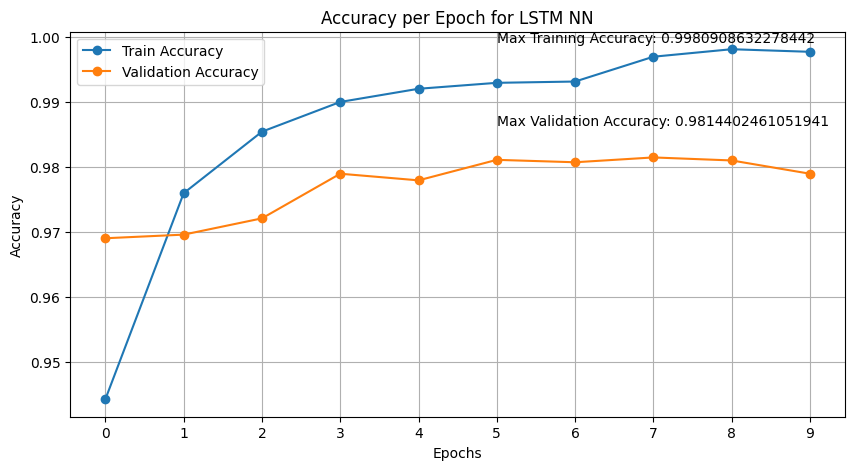

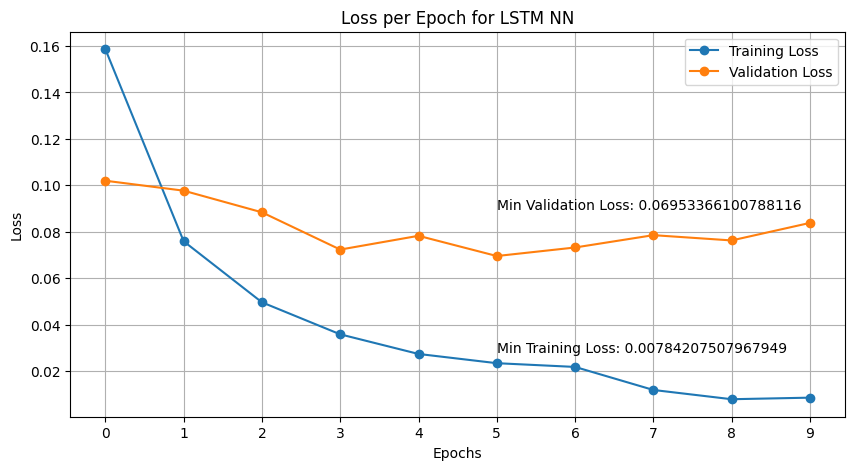

In [22]:
# print(model.history.history)
train_acc = model.history.history["acc"].copy()
valid_acc = model.history.history["val_acc"].copy()
maxTrain = 0
maxValid = 0
for i in range(len(train_acc)):
    if train_acc[i] > maxTrain:
        maxTrain = train_acc[i]
    if valid_acc[i] > maxValid:
        maxValid = valid_acc[i]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Train Accuracy", marker = "o")
plt.plot(valid_acc, label="Validation Accuracy", marker = "o")
plt.annotate("Max Training Accuracy: "+str(maxTrain), xy=(7, maxTrain), xytext=(5, maxTrain+0.001))
plt.annotate("Max Validation Accuracy: "+str(maxValid), xy=(7, maxValid), xytext=(5, maxValid+0.005))
plt.grid()
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy per Epoch for LSTM NN")
plt.xticks(np.arange(0, 10, 1))
plt.show()

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

minTrain = 100
minValid = 100
for i in range(len(train_loss)):
    if train_loss[i] < minTrain:
        minTrain = train_loss[i]
    if valid_loss[i] < minValid:
        minValid = valid_loss[i]     
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Training Loss", marker = "o")
plt.plot(valid_loss, label="Validation Loss", marker = "o")
plt.annotate("Min Training Loss: "+str(minTrain), xy=(7, minTrain), xytext=(5, minTrain+0.02))
plt.annotate("Min Validation Loss: "+str(minValid), xy=(7, minValid), xytext=(5, minValid+0.02))
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss per Epoch for LSTM NN")
plt.xticks(np.arange(0, 10, 1))
plt.legend()
plt.show()

We can see by the two graphs above that the model is slightly overfitting, however, the model is still performing well. The model is able to predict whether a news report is fake or real with an accuracy of 98.03% on the validation set and a 99.8% on the training set.

In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Accuracy: ", accuracy_score(y_test, y_pred))



281/281 [==============================] - 4s 12ms/step
Accuracy:  0.9787305122494432


We can see that the model also performs well on the test set with an accuracy of 98.15%.

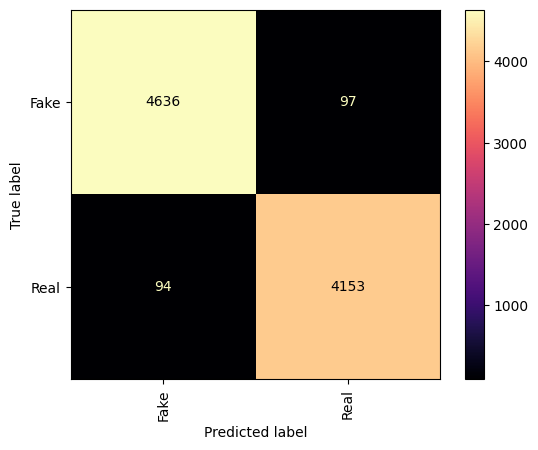

In [24]:
categories = ["Fake", "Real"]
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = categories)
cm_display.plot(cmap = "magma")
plt.xticks(rotation = 90)
plt.savefig("ConfusionMatrix.png")
plt.show()

We see from the confusion matrix above that the model is able to predict fake and real reports with a high accuracy by displaying a small degree of wrong predictions. 

### Supervised Classifiers 

Comparing then performance of the LSTM neural network to supervised classifiers such as Random Forest, K-nn classifier and Gradient Boosting.

#### Random Forest
Decision trees are prone to overfitting, thus random forest is an ensemble of decision trees, each decision tree is trained on a random subset of the data and a random subset of the features. The predictions of each decision tree are then averaged to get the final prediction. This reduces the variance of the model and thus reduces overfitting.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rfAcc = []
maxAcc = 0
max_yhat = []
for i in range(1,51,5):
    clf = RandomForestClassifier(max_depth = i)
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_test)
    rfAcc.append(metrics.accuracy_score(y_test, y_hat))
    if metrics.accuracy_score(y_test, y_hat) > maxAcc:
        maxAcc = metrics.accuracy_score(y_test, y_hat)
        max_yhat = y_hat



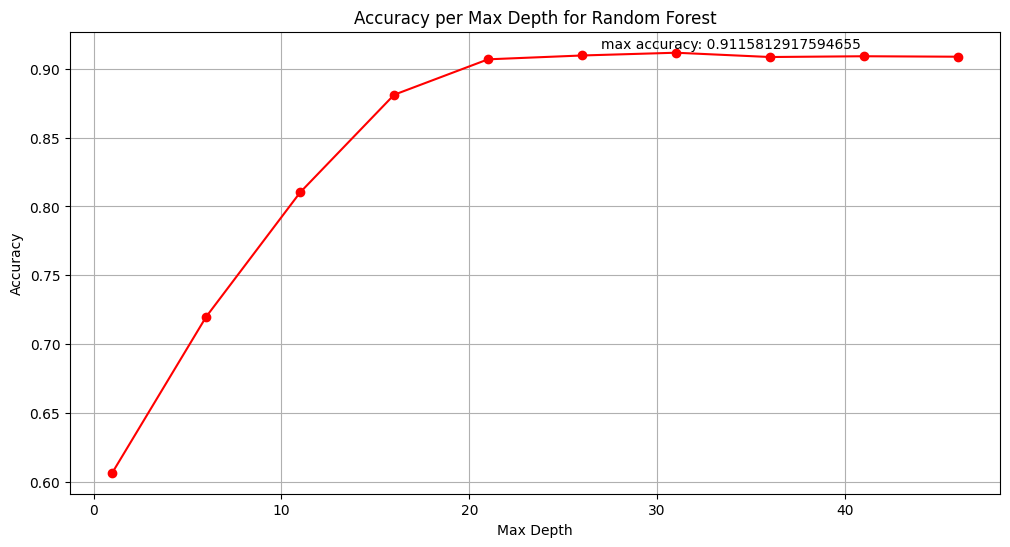

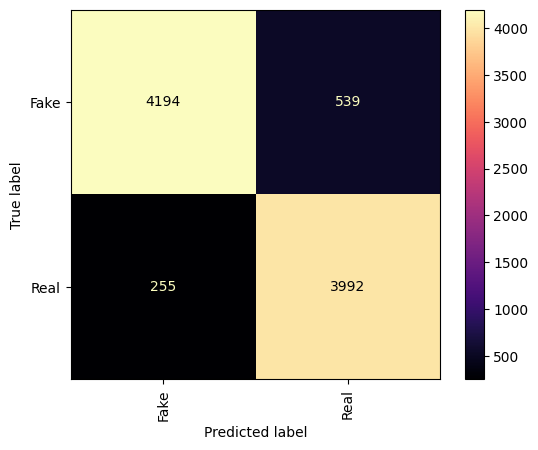

In [26]:
maxindexRf = 0
maxAmount = -1
for i in range(len(rfAcc)):
    if rfAcc[i] > maxAmount:
        maxAmount = rfAcc[i]
        maxindexRf = i
plt.figure(figsize=(12,6))
plt.annotate(f"max accuracy: {rfAcc[maxindexRf]}", xy=(27, 0.915), xytext=(27, 0.915))
plt.plot(range(1,51,5), rfAcc, color='red', marker='o',)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy per Max Depth for Random Forest')
plt.grid()
plt.show()

categories = ["Fake", "Real"]
cm = confusion_matrix(y_test, max_yhat)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = categories)
cm_display.plot(cmap = "magma")
plt.xticks(rotation = 90)
plt.savefig("ConfusionMatrix.png")
plt.show()

We observe that the random forest model is able to predict fake and real news reports with an accuracy of 91.3% on the test set. This is less than the accuracy of the LSTM model. The confusion matrix shows that the model is able to predict fake and real news reports with a high accuracy by displaying a small degree of wrong predictions.

#### K-nearest neighbors
K-nearest neighbors is a supervised learning algorithm that can be used for both classification and regression. It is a non-parametric method that stores all available cases and classifies new cases based on a similarity measure. The similarity measure is the Euclidean distance between the new case and the stored cases. The new case is then classified based on the majority of the k nearest neighbors.

In [27]:
from sklearn.neighbors import KNeighborsClassifier
KnAcc = []
maxAcc = 0
max_yhat = []
for i in range(1,51, 5):
    knn = KNeighborsClassifier(n_neighbors = i, weights='distance', algorithm='brute')
    knn.fit(x_train, y_train)
    y_hat = knn.predict(x_test)
    KnAcc.append(metrics.accuracy_score(y_test, y_hat))
    if metrics.accuracy_score(y_test, y_hat) > maxAcc:
        maxAcc = metrics.accuracy_score(y_test, y_hat)
        max_yhat = y_hat

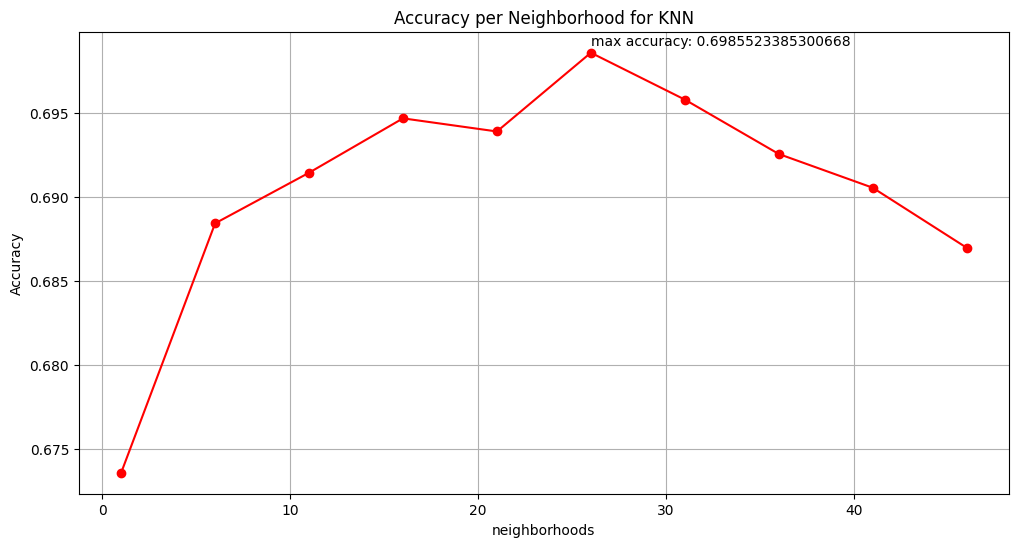

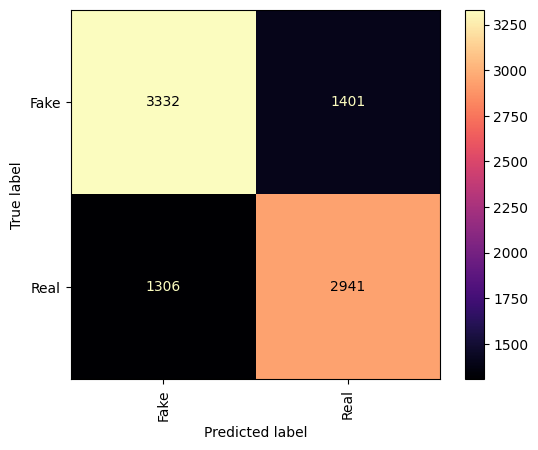

In [28]:
plt.figure(figsize=(12,6))
plt.plot(range(1,51, 5), KnAcc, color='red', marker='o',)
maxindexKn = 0
maxAmount = -1
for i in range(len(KnAcc)):
    if KnAcc[i] > maxAmount:
        maxAmount = KnAcc[i]
        maxindexKn = i
plt.annotate(f"max accuracy: {KnAcc[maxindexKn]}", xy=(26, 0.695), xytext=(26, 0.699))
plt.xlabel('neighborhoods')
plt.ylabel('Accuracy')
plt.title('Accuracy per Neighborhood for KNN')
plt.grid()
plt.show()

categories = ["Fake", "Real"]
cm = confusion_matrix(y_test, max_yhat)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = categories)
cm_display.plot(cmap = "magma")
plt.xticks(rotation = 90)
plt.savefig("ConfusionMatrix.png")
plt.show()

We see that the K-nearest neighbors model is able to predict fake and real news reports with an accuracy of 69.85% on the test set. The confusion matrix shows that for both real and fake news that the model equally misses about 25% of each category in the test set.

#### Graident Boosting
Gradient Boosting Classifier is an ensemble of decision trees. It is a boosting algorithm that builds a model in a stage-wise fashion. It builds the model in a forward stage-wise fashion. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. In each stage, n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbAcc = []
maxAcc = 0
max_yhat = []
for i in range(1,200,5):
    gb = GradientBoostingClassifier(n_estimators=i, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
    gb.fit(x_train, y_train)
    y_hat = gb.predict(x_test)
    gbAcc.append(metrics.accuracy_score(y_test, y_hat))
    if metrics.accuracy_score(y_test, y_hat) > maxAcc:
        maxAcc = metrics.accuracy_score(y_test, y_hat)
        max_yhat = y_hat



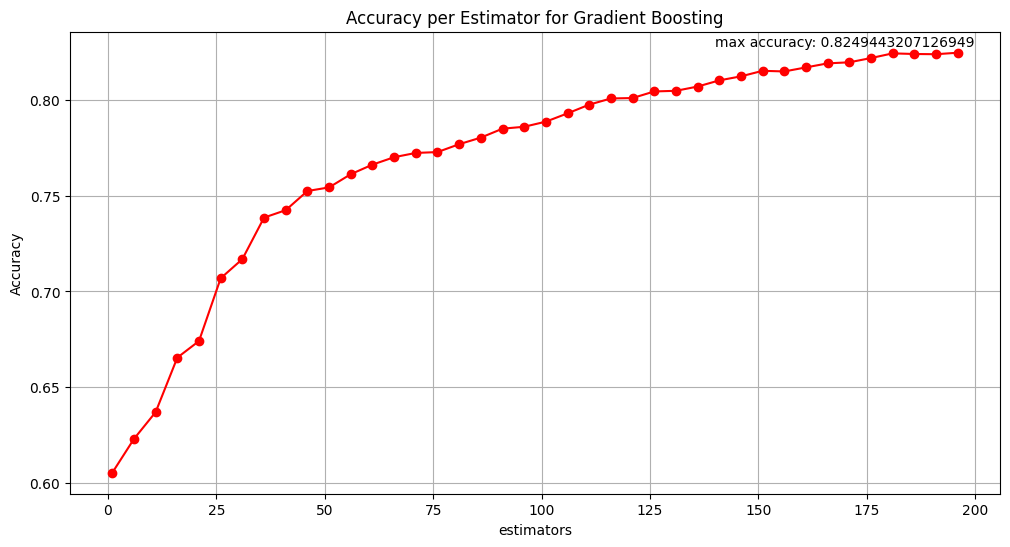

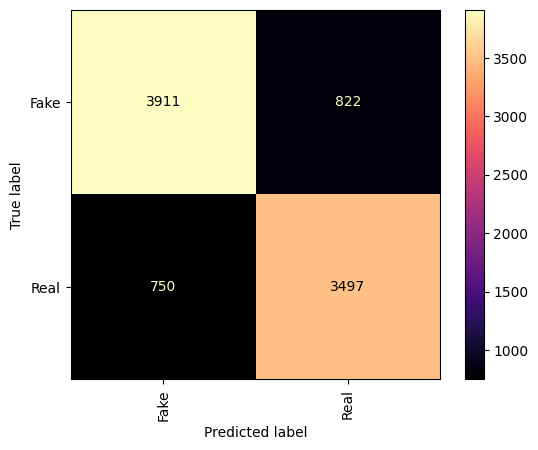

In [30]:
maxindexGb = 0
maxAmount = -1
for i in range(len(gbAcc)):
    if gbAcc[i] > maxAmount:
        maxAmount = gbAcc[i]
        maxindexGb = i
plt.figure(figsize=(12,6))
plt.plot(range(1,200, 5), gbAcc, color='red', marker='o',)
plt.annotate(f"max accuracy: {gbAcc[maxindexGb]}", xy=(180, 0.825), xytext=(140, 0.828))
plt.xlabel('estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy per Estimator for Gradient Boosting')
plt.grid()
plt.show()

categories = ["Fake", "Real"]
cm = confusion_matrix(y_test, max_yhat)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = categories)
cm_display.plot(cmap = "magma")
plt.xticks(rotation = 90)
plt.savefig("ConfusionMatrix.png")
plt.show()

From the results above, the best test accuracy is 82.49% from the gradient boosting classifier. The confusion matrix shows that the model is able to predict fake and real news reports with a high accuracy by displaying a small degree of wrong predictions. 

### Results
From the above results, we can see that the LSTM model out performed the supervised classifiers, this is because the LSTM model is able to learn the context of the text by using a recurrent layer in a neural network and thus is able to make better predictions. Random Forest classifier performed second best, then gradient boosting and finally K-nn classifier. 

Out of the supervised classifiers, the random forest classifier performed the best because it is an ensemble of decision trees and thus reduces the variance of the model, which reduces overfitting. While the gradient boosting classifier performed second best, it is prone to overfitting and thus is not as good as the random forest classifier. Finally, the K-nn classifier performed the worst, this is because it is a non-parametric method that stores all available cases and classifies new cases based on a similarity measure. This means that the K-nn classifier is not able to learn the context of the text and thus is not able to make good predictions.

Thus, we can conclude that using LSTM to classify text, results in a 98% success rate when testing from the test set. This is a good result as it means that the model is able to predict whether a news report is fake or real with a high accuracy.